In [ ]:
!pip install lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 21.5 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import lightning as L
from torch.nn import functional as F
from torch.utils.data import DataLoader

In [ ]:
from torch.optim import adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid
from torchvision import datasets, transforms

In [ ]:
transform = transforms.Compose([transforms.ToTensor()]) # assigninig the variable function to transform to tensor

In [ ]:
from pytorch_lightning.callbacks import ProgressBar
from pytorch_lightning.loggers import CSVLogger

In [ ]:
path = '~/datasets'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 63587563.88it/s]


Extracting /root/datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 50769360.36it/s]

Extracting /root/datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 28122182.13it/s]


Extracting /root/datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 11680275.15it/s]

Extracting /root/datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # cuda implementatation

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size= batch_size , shuffle = True)
test_loader = DataLoader(dataset=test_dataset, batch_size= batch_size , shuffle = True) # creates the required datasets

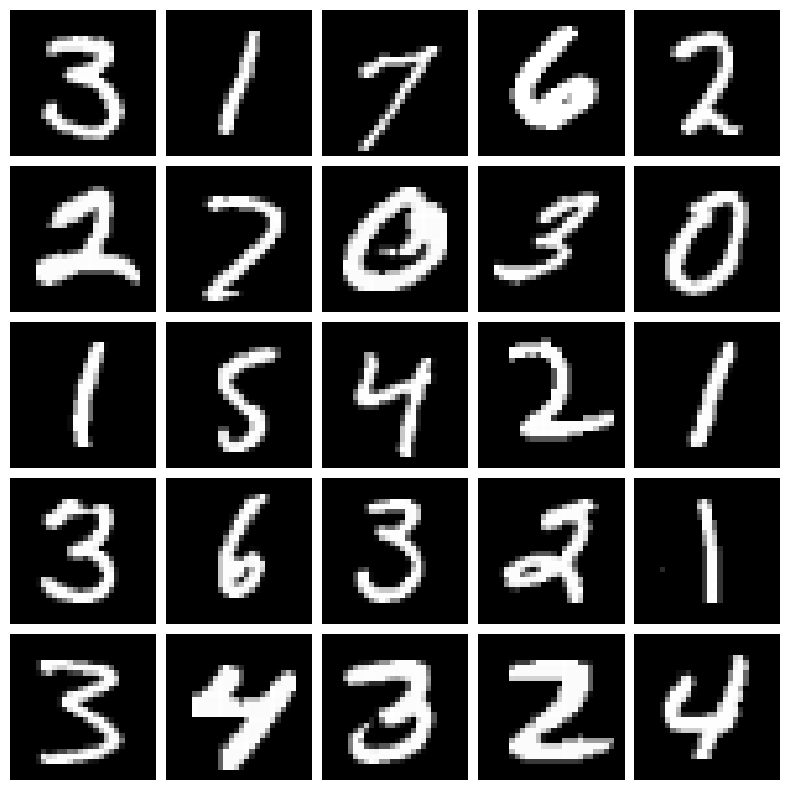

In [ ]:
dataiter = iter(train_loader)
image = next(dataiter) # make sure to not use dataiter.next()

num_samples = 25
sample_images = [image[0][i,0] for i in range(num_samples)]
fig = plt.figure(figsize=(10,10)) # defining the images and its sizes
grid = ImageGrid(fig, 111, nrows_ncols=(5,5), axes_pad=0.1) #padding and other stuff


for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

In [ ]:
class Encoder(nn.Module): # take an input and transform it into a representation in latent space.
  def __init__(self, input_dim=784, hidden_dim=512, latent_dim=256): # latent dimension is set smaller than the actual hidden dim to compress the image
    super(Encoder,self).__init__()

    self.linear1 = nn.Linear(input_dim,hidden_dim)
    self.linear2 = nn.Linear(hidden_dim,hidden_dim)
    self.mean = nn.Linear(hidden_dim, latent_dim)
    self.var = nn.Linear(hidden_dim, latent_dim)
    self.LeakyReLU = nn.LeakyReLU(0.2)
    self.train = True

  def forward(self,x):
    x  = self.LeakyReLU(self.linear1(x))
    x  = self.LeakyReLU(self.linear2(x))

    mean = self.mean(x)
    log_var = self.var(x)
    return mean , log_var





    #Inside the initializer, the class sets up two linear layers (linear1 and linear2)
    #that progressively transform the input data to the hidden dimensions. T
    #here are also two additional linear layers (mean and var) that output
    #the parameters for the latent distribution: mean and variance (technically, log variance).




In [ ]:
class Decoder(nn.Module): # take an input and transform it into a representation in latent space.
  def __init__(self, output_dim=784, hidden_dim=512, latent_dim=256): # latent dimension is set smaller than the actual hidden dim to compress the image
    super(Encoder,self).__init__()

    self.linear1 = nn.Linear(latent_dim,hidden_dim)
    self.linear2 = nn.Linear(hidden_dim,hidden_dim)
    self.output = nn.Linear(hidden_dim,output_dim)
    self.LeakyReLU = nn.LeakyReLU(0.2)

  def forward(self,x):
    x  = self.LeakyReLU(self.linear1(x))
    x  = self.LeakyReLU(self.linear2(x))

    x_hat = torch.sigmoid(self.output(x))
    return x_hat




In [ ]:
from typing import Any, Callable

from lightning.pytorch.core.optimizer import LightningOptimizer
from torch.optim.optimizer import Optimizer


class VAELightning(L.LightningModule):

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200):
        super(VAELightning,self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim


        self.encoder = nn.Sequential(
                                     nn.Linear(input_dim,hidden_dim),
                                     nn.LeakyReLU(0.2),
                                     nn.Linear(hidden_dim,latent_dim),
                                     nn.LeakyReLU(0.2)
                                     )

        self.mean_layer = nn.Linear(latent_dim,2)
        self.log_var = nn.Linear(latent_dim,2)

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )
        # eps stands for epsilon, which is a randomly sampled value used in the reparameterization trick.


    def encode(self,x):
        x = self.encoder(x)
        mean = self.mean_layer(x)
        logvar = self.log_var(x)
        return mean ,logvar


        # mean: The mean (μμ) of the latent space distribution for each data point.
        # logvar: The logarithm of the variance (log(σ2σ2)) of the latent space distribution


        # Reparameterisation - rucial for enabling gradient flow during backpropagation through stochastic nodes, as directly sampling from the latent distribution would block gradients.
        # Computes the latent variable (z) by adding the element-wise product of the noise
        # tensor and the standard deviation to the mean. This results in a differentiable transformation that incorporates randomness: z=μ+σ×ϵz=μ+σ×ϵ.




    def reparameterisation(self,mean,logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.rand_like(std) #Returns a tensor with the same size as input that is filled with random numbers from a normal distribution with mean 0 and variance 1.

        z = mean + std*eps
        return z




    def decode(self,z):
        return self.decoder(z)




      # Input (x): The input data that needs to be encoded into a latent representation.

    def forward(self,x):
        mean, logvar = self.encode(x.view(-1, self.input_dim))
        z = self.reparameterisation(mean,logvar)
        xhat = self.decode(z)
        return logvar, xhat , mean



    def training_step(self,batch, batch_idx): # training step needs batch and batch index needed
        x, _ = batch
        mean, logvar = self.encode(x.view(-1, self.input_dim))
        # Reconstruction loss + KL divergence losses summed over all elements and batch
        z = self.reparameterisation(mean,logvar)
        xhat = self.decode(z)
        # reconstruction loss and kl divergence for VAE
        recon_loss = nn.functional.binary_cross_entropy(xhat, x.view(-1, self.input_dim), reduction='sum')
        kl_div = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

        loss = recon_loss + kl_div

        # Log the losses for TensorBoard and for viewing during training
        self.log('train_loss', loss, prog_bar=True, logger=True)
        self.log('recon_loss', recon_loss, prog_bar=True, logger=True)
        self.log('kl_div', kl_div, prog_bar=True, logger=True)

        print(f"Epoch: {self.current_epoch}, Batch idx: {batch_idx}, Loss: {loss.item()}")

        return loss

    def configure_optimizers(self):
        return Adam(self.parameters(),lr = 0.001)


    def train_dataloader(self):
        transform = transforms.Compose([
            transforms.ToTensor(),  # Converts to [0, 1]
            # Ensure the target data is also scaled to [0, 1], no additional normalization needed for this use case
        ])
        dataset = datasets.MNIST('', train=True, download=True, transform=transform)
        return DataLoader(dataset, batch_size=64, shuffle=True)


In [ ]:
# Logger
logger = CSVLogger(save_dir='logs/', name='my_model')

# Progress Bar
progress_bar = ProgressBar()


In [ ]:
parth_VAE = VAELightning()

In [ ]:
# training

trainer = L.Trainer(max_epochs = 10)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
from torch.optim import Adam

In [ ]:
trainer.fit(parth_VAE)


INFO: 
  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | encoder    | Sequential | 394 K  | train
1 | mean_layer | Linear     | 402    | train
2 | log_var    | Linear     | 402    | train
3 | decoder    | Sequential | 395 K  | train
--------------------------------------------------
790 K     Trainable params
0         Non-trainable params
790 K     Total params
3.162     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | encoder    | Sequential | 394 K  | train
1 | mean_layer | Linear     | 402    | train
2 | log_var    | Linear     | 402    | train
3 | decoder    | Sequential | 395 K  | train
--------------------------------------------------
790 K     Trainable params
0         Non-trainable params
790 K     Total params
3.162     Total e

Training: |          | 0/? [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
Epoch: 4, Batch idx: 624, Loss: 9155.001953125
Epoch: 4, Batch idx: 625, Loss: 9146.8974609375
Epoch: 4, Batch idx: 626, Loss: 9558.4423828125
Epoch: 4, Batch idx: 627, Loss: 9387.869140625
Epoch: 4, Batch idx: 628, Loss: 10355.8212890625
Epoch: 4, Batch idx: 629, Loss: 9502.9521484375
Epoch: 4, Batch idx: 630, Loss: 8996.1416015625
Epoch: 4, Batch idx: 631, Loss: 9976.4716796875
Epoch: 4, Batch idx: 632, Loss: 10096.5869140625
Epoch: 4, Batch idx: 633, Loss: 9594.7587890625
Epoch: 4, Batch idx: 634, Loss: 9322.9697265625
Epoch: 4, Batch idx: 635, Loss: 9835.6474609375
Epoch: 4, Batch idx: 636, Loss: 9400.9619140625
Epoch: 4, Batch idx: 637, Loss: 9496.0048828125
Epoch: 4, Batch idx: 638, Loss: 9677.357421875
Epoch: 4, Batch idx: 639, Loss: 9950.0908203125
Epoch: 4, Batch idx: 640, Loss: 8587.259765625
Epoch: 4, Batch idx: 641, Loss: 9358.224609375
Epoch: 4, Batch idx: 642, Loss: 9014.82421875
Epoch: 4, Batch idx: 643, Loss: 9370.95996

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch: 9, Batch idx: 934, Loss: 9113.890625
Epoch: 9, Batch idx: 935, Loss: 9117.1826171875
Epoch: 9, Batch idx: 936, Loss: 9526.279296875
Epoch: 9, Batch idx: 937, Loss: 4592.11767578125


In [ ]:
def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    # The to(device) method ensures that the tensor is moved to the appropriate device (either CPU or GPU).
    # Here, parth_VAE.decode(z_sample) passes the latent variable z_sample through the decoder network of your VAE.
    x_decoded = parth_VAE.decode(z_sample)
    # ensures that the gradient tracking for this tensor is stopped (as you're not performing backpropagation in this inference step).
    digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
    # reshapes the array into its standard mnist dimensions

    #final plotting and planning
    plt.title(f'[{mean},{var}]')
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

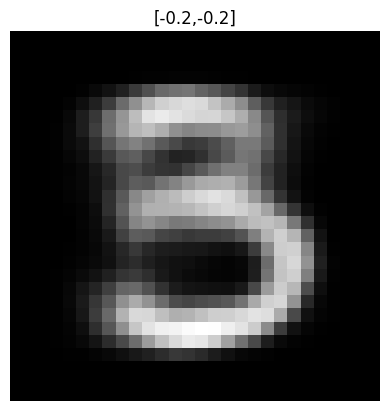

In [ ]:
# The mean value determines the central location of the latent variable z in the latent space. In a well-trained VAE,
# mean: This shifts the generated digit to a different class or type.
# The digit generated will change its visual appearance, transitioning between different digits or variations of the same digit.
# var: This controls the sharpness or clarity of the digit.
# A higher variance adds more randomness and can result in noisier, blurrier digits, while a lower variance will make the output sharper and more predictable.


generate_digit(-0.2,-0.2)

In [ ]:
def latent_space(parth_VAE,scale = 5.0, n=25 , digit_size= 28, figsize= 15):
    # display a n*n manifold of the digits
    figure = np.zeros((digit_size * n, digit_size * n))

    #construct a grid
    grid_x =np.linspace(-scale,scale,n)
    grid_y = np.linspace(-scale,scale,n)[::-1]

    # The nested loops iterate over each point (xi, yi) in the grid.
    #For each point, a latent variable tensor z_sample is created and passed through the model’s decode function.
    #The resulting output (x_decoded) is processed (detached from gradients, moved to CPU, and reshaped)
    #to get a digit_size by digit_size image, which is then placed in the correct position in the figure array.
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = parth_VAE.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size] = digit

    # Plotting and planning

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


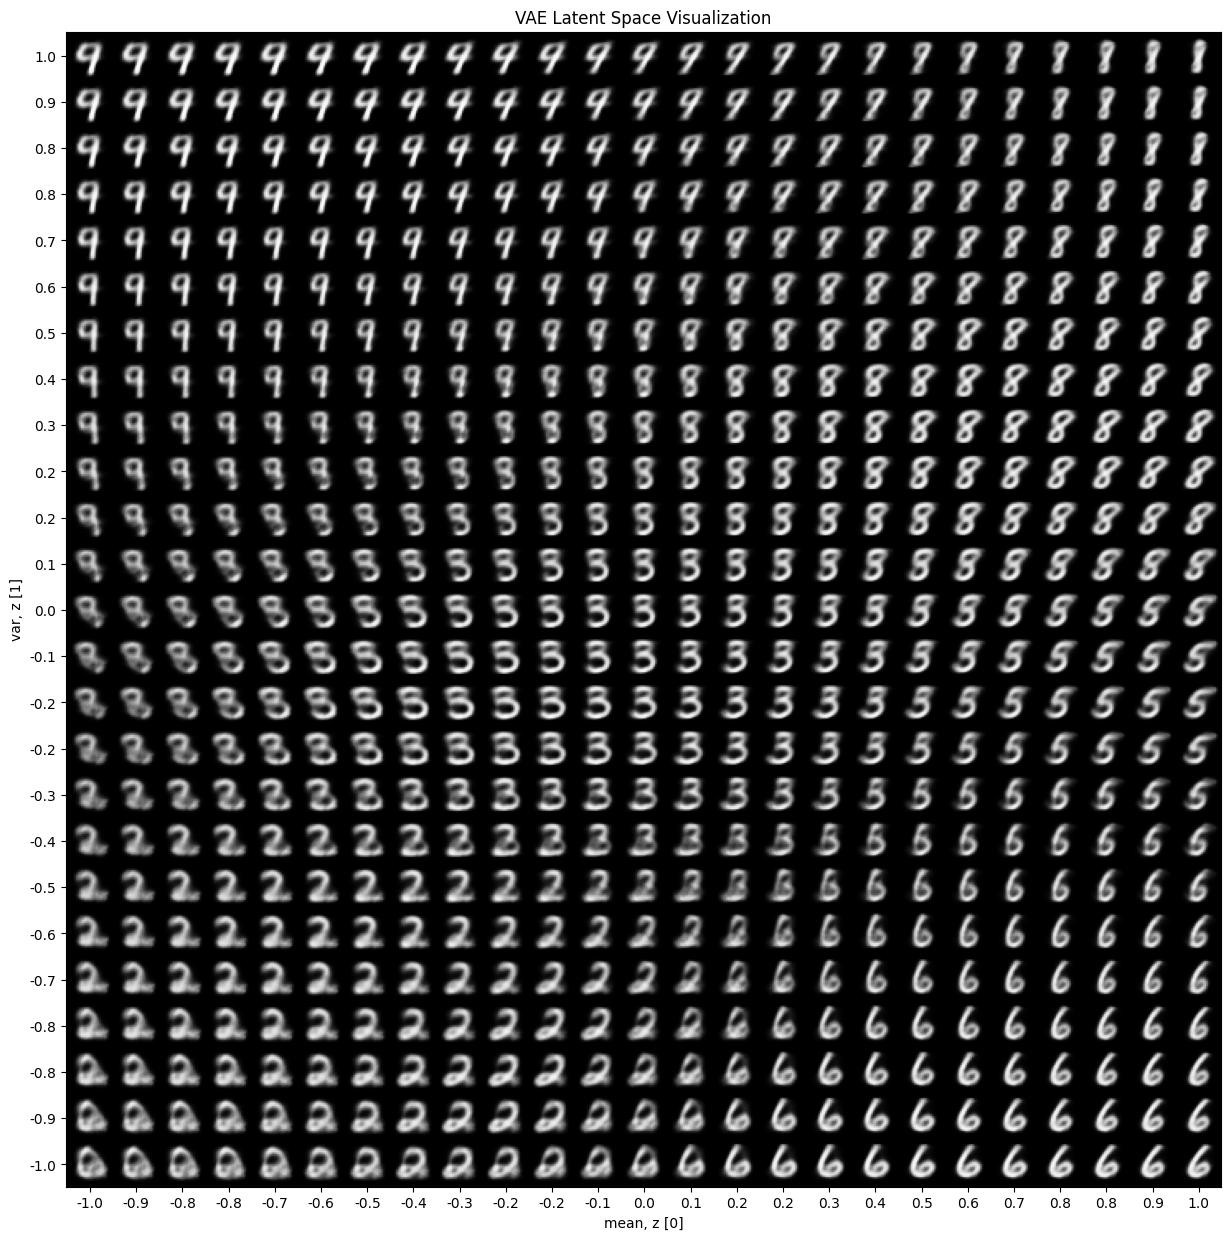

In [ ]:
latent_space(parth_VAE, scale= 1.0)